# AdaLine (Adaptive Linear Neuron)

**Course**: Computer Vision (911.908)    
**Author**: Roland Kwitt (Dept. of Computer Science, Univ. of Salzburg)       
Winter term 2019/20

In this example, we briefly look at **AdaLine**, i.e., a simple early neural network model (Widrow & Hoff, 1960) which can easily be trained (with gradient descent) using PyTorch.

Basically, the adaptive linear neuron is very similar to the Perceptron, with the only difference that the activation function is **linear**.

---

## Contents

- [Model](#Model)
- [Learning rule](#AdaLine-learning-rule)
- [Implementation](#Implementation)

---

## Model

We are given $(\mathbf{x}_i,y_i)$ for $i=1,\ldots,n$ with $\mathbf{x}_i \in \mathbb{R}^n$ and $y_i \in \{0,1\}$. Also, we augment $\mathbf{x}_i$ by 1 at position 0 to obtain $\mathbf{x}_i = [1,x_{i1},\ldots,x_{in}]^\top \in \mathbb{R}^{n+1}$. Similar to the perceptron, we compute

$$ \hat{y} = f(\mathbf{x},\mathbf{w}) = \phi(\langle \mathbf{w},\mathbf{x}\rangle)$$

where $\mathbf{w} = [w_0,w_1,\ldots,w_n]^\top$ includes the bias term $w_0$ and

$$
\phi(z) = \mathbf{1}_{z>0.5} = \begin{cases}
1, & \text{if}~z>1/2 \\
0, & \text{else}
\end{cases}
$$

is a simple threshold function at $1/2$. Another difference to the Perceptron is in the *learning rule*: specifically, we *do not* measure whether we were correct at the output (under 0/1 loss), but rather consider the *mean-squared-error* after the activation function with respect to the target (which is in $\{0,1\}$).



<img src="Adaline.svg" alt="drawing" width="400"/>

At evaluation time, we obviously use the threshold to decide whether a new $\mathbf{x}^*$ should be assigned 0 or 1.

---

## AdaLine learning rule

The original AdaLine learning rule (aka *Widrow-Hoff* learning rule) updates the weights $\mathbf{w}^{(t)}$ via

$$ \mathbf{w}^{(t+1)} \leftarrow \mathbf{w}^{(t)} + \eta(d-o)\mathbf{x}$$

per sample, where $o$ is the output after the identity function and $d$ is the label of the input sample
$\mathbf{x}$.

### Justification

Lets omit the iteration identifier $t$ for a second and also omit the indices, $i$, of the training samples.
Let $\mathbf{x} = [1,x_1,x_2,\ldots,x_n]^\top$ be an input sample in $\mathbb{R}^{n+1}$ (with a 1 added to include bias). This allows us to write

$$ u = \mathbf{w}^\top x$$

Upon applying the identity activation function, we get

$$ o = \text{id}(u)$$

Lets compute the squared error:

$$E = (o - d)^2$$

and take the partial derivative of $E$ wrt. $\mathbf{w}$:

$$\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial (o-d)^2}{\partial \mathbf{w}} = 2(o-d)\frac{\partial o}{\partial \mathbf{w}} = 2(o-d)\frac{\partial u}{\partial \mathbf{w}} = 2(o-d)\frac{\partial \mathbf{w}^\top \mathbf{x}}{\partial \mathbf{w}} = 2(o-d)\mathbf{x}$$

The negative of this gradient (which we need for gradient descent based learning) is 

$$-\frac{\partial E}{\partial \mathbf{w}} = 2(d-o)\mathbf{x}$$

We know that moving along the direction of the negative gradient decreases the error; finally, we obtain the original AdaLine learning rule where the factor 2 is simply merged into the learning rate $\eta$.

## Implementation

In [183]:
import torch
from torch.autograd import grad
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Let's read-in some actual data into a `pandas` DataFrame.

In [184]:
df = pd.read_csv(
    'iris.data', 
    index_col=None,
    header=None)

Next, we want to construct a binary classification problem, where class 0 is `Iris-versicolor` and everything else is class 1.

In [185]:
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df = df.iloc[50:150]
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1) # make the problem binary

# use x2 and x3 to make up our inputs x = [x2,x3]
X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

# take 70% of the data for training, the remaining 30% for testing
percent70 = int(shuffle_idx.size(0)*0.7)
X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# normalize (mean zero, unit variance) - we only use the mean and std. dev of 
# the training data, since this is the only data we have access to in practice!
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Ok, lets plot the input data points, colored by class (this is our training data).

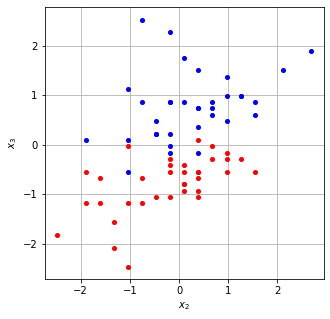

In [186]:
plt.figure(figsize=(5,5))
plt.plot(X_train[np.where(y_train==0)[0],0],X_train[np.where(y_train==0)[0],1], 'r.', markersize=8);
plt.plot(X_train[np.where(y_train==1)[0],0],X_train[np.where(y_train==1)[0],1], 'b.', markersize=8);
plt.grid()
plt.xlabel('$x_2$');
plt.ylabel('$x_3$');

We are now ready to define our **Adaline** model. This is effectively a simple linear model (computing an inner product + bias). We will define the model in the way we will later define more complex neural networks, i.e., using a class derived from `nn.Module`.


In [187]:
class Adaline(torch.nn.Module):
    def __init__(self, num_features):
        super(Adaline, self).__init__()

        # implements <w,x>+b
        self.linear = torch.nn.Linear(num_features, 1) 
        
        # initialize weights and bias to 0
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        u = self.linear(x)   # u = <w,x>+b
        o = u                # activation = identity
        return o.view(-1)    # vectorize

Next, we define how we measure the **quality** of the network output (i.e., the predictions). In Adaline, this is simply a mean-squared error, measuring the squared difference between the network output (after the activation function) and the desired values.

In [188]:
def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    
    cost = []
    torch.manual_seed(seed)
    
    # set the optimizer to SGD 
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=learning_rate)
    
    model.train()
    
    # Run num_epoch times over the training data
    for e in range(num_epochs):
        
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

        # create indices for mini-batches 
        minibatches = torch.split(
            shuffle_idx, 
            minibatch_size)
        
        # compute gradient w.r.t. this selection of samples
        for minibatch_idx in minibatches:

            yhat = model.forward(x[minibatch_idx])     # forward pass
            loss = F.mse_loss(yhat, y[minibatch_idx])  # compute loss (i.e., mean-squared error)
            optimizer.zero_grad()                      # set gradients to zero
            loss.backward()                            # backward pass to compute gradients
            optimizer.step()                           # update the AdaLine parameters (w,b)

        # compute the loss over ALL training data - with lots of data, you would also 
        # do this over mini batches!
        with torch.no_grad():
            yhat = model.forward(x)
            curr_loss = F.mse_loss(yhat, y)
            print('Epoch: %03d' % (e+1), end="")
            print(' | MSE: %.5f' % curr_loss)
            cost.append(curr_loss)

    return cost

Lets instantiate this model and train!

Epoch: 001 | MSE: 0.38849
Epoch: 002 | MSE: 0.31679
Epoch: 003 | MSE: 0.26379
Epoch: 004 | MSE: 0.22463
Epoch: 005 | MSE: 0.19527
Epoch: 006 | MSE: 0.17307
Epoch: 007 | MSE: 0.15629
Epoch: 008 | MSE: 0.14352
Epoch: 009 | MSE: 0.13360
Epoch: 010 | MSE: 0.12600
Epoch: 011 | MSE: 0.12007
Epoch: 012 | MSE: 0.11547
Epoch: 013 | MSE: 0.11178
Epoch: 014 | MSE: 0.10884
Epoch: 015 | MSE: 0.10656
Epoch: 016 | MSE: 0.10470
Epoch: 017 | MSE: 0.10320
Epoch: 018 | MSE: 0.10200
Epoch: 019 | MSE: 0.10105
Epoch: 020 | MSE: 0.10025


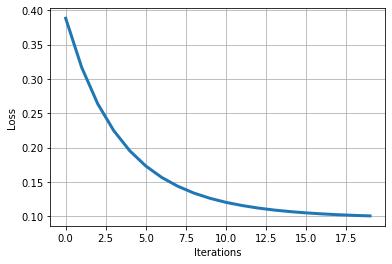

In [189]:
model = Adaline(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

plt.plot(cost, linewidth=3);
plt.xlabel('Iterations');
plt.ylabel('Loss');
plt.grid()

We are now ready to evaluate the performance of the Adaline network on **training** data:

In [190]:
# set model to evaluation mode
model.eval()

# run a forward pass through model, detach the result 
# from the comp. graph and convert it to a numpy array
yhat_train = model.forward(X_train).detach().numpy()

# create an array of all-zeros
ylab_train = np.zeros_like(yhat_train, dtype=np.int32)

# apply threshold (at 0.5): predictions > 0.5 get label 1, all others are 0
ylab_train[np.where(yhat_train>0.5)[0]]=1

# compute accuracy
print('Train accuracy: {:.3f}'.format((ylab_train == y_train.numpy()).sum()/len(ylab_train)))

Train accuracy: 0.929


... and now on unseen **testing** data:

In [191]:
model.eval()
yhat_test = model.forward(X_test).detach().numpy()

ylab_test = np.zeros_like(yhat_test, dtype=np.int32)
ylab_test[np.where(yhat_test>0.5)[0]]=1

print('Test accuracy: {:.3f}'.format((ylab_test == y_test.numpy()).sum()/len(ylab_test)))

Test accuracy: 0.933


## More convenience via `Dataset` and `DataLoader`

In [196]:
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        
        self.X = X.astype('float32')
        self.y = y.astype('float32')
        
        assert(self.X.shape[0] == self.y.shape[0])
        
    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]

    def __len__(self):
        return self.X.shape[0]
    

def get_data(file_name, p=0.7):
    df = pd.read_csv(file_name, index_col=None, header=None)
    df = df.iloc[50:150]
    df.columns = ['x1', 
                  'x2', 
                  'x3', 
                  'x4', 
                  'y']
    
    df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
    
    shuffle_idx =  np.random.permutation(len(df))
    X = df[['x2', 'x3']].values[shuffle_idx]
    y = df['y'].values[shuffle_idx]
    
    N = int(len(shuffle_idx)*p)
    X_trn, X_tst = X[shuffle_idx[:N]], X[shuffle_idx[N:]]
    y_trn, y_tst = y[shuffle_idx[:N]], y[shuffle_idx[N:]]
    
    mu, sigma = X_trn.mean(axis=0), X_trn.std(axis=0)
    X_trn = (X_trn - mu) / sigma
    X_tst = (X_tst - mu) / sigma
    
    return X_trn, y_trn, X_tst, y_tst

In [197]:
from torch.utils.data import DataLoader

X_trn, y_trn, X_tst, y_tst = get_data('iris.data')

ds_trn = CustomDataSet(X_trn, y_trn)
ds_tst = CustomDataSet(X_tst, y_tst)

dl_trn = DataLoader(ds_trn, batch_size=10, shuffle=True)
dl_tst = DataLoader(ds_tst, batch_size=10, shuffle=False)

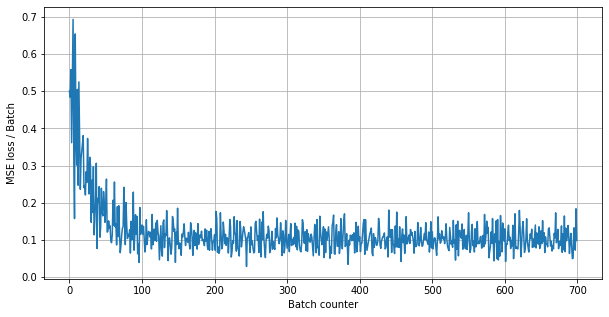

In [198]:
model = Adaline(num_features=2)
optim = torch.optim.SGD(model.parameters(), lr=0.01)

it_loss = []

# epochs
for n_epoch in range(100):
    
    # batches
    for x, target in dl_trn:
        
        # forward
        yhat = model(x)
        
        # loss
        loss = F.mse_loss(yhat, target) 
        
        # zero-out gradients
        optim.zero_grad()
        
        # gradient comp.
        loss.backward()
        
        # update parameters
        optim.step()
        
        # track MSE loss
        it_loss.append(loss.item())   

plt.figure(figsize=(10,5))
plt.plot(it_loss)
plt.xlabel('Batch counter');
plt.ylabel('MSE loss / Batch');
plt.grid()

In [199]:
model.eval()
correct = 0
for x, target in dl_tst:
    y = model(x).detach().numpy()
    yhat = np.zeros_like(y)
    yhat[np.where(y>0.5)[0]]=1
    correct += (yhat == target.numpy()).sum()

print('Test accuracy: {:.2f}'.format(correct/len(ds_tst)))

Test accuracy: 1.00
